# Subject: Advance Mathematical Applications for Deep Learning II

# Project_II: Human Emotion Detection

### Team Member: Virajkumar Tank (101411542)

Choice of Probelm: Original dataset consist Images of 7 differnt classes of single label emotion detection which will be converted into multi-label and also will make it compatible to pre-trained model like VGG16 and VGG19.

Problem Statement: As an Extention (Exploration) of Project_I, I am going to do multi-label emotion detection by using VGG16 and VGG19 Pre-trained model.

Original Dataset Link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/code?resource=download

Data Description: 

1)Set the path to the image folder. 
2)Create an empty list to store the image file names, their corresponding labels, and pixel data.
3)Define the desired size of the images. Loop through each emotion folder in the image directory and for each image in   that folder: Check if the file has a ".png" extension. 
4)Load the image using the Python Imaging Library (PIL). Convert the image to grayscale using the "convert" method. 5)Resize the image to the desired size using the "resize" method. Convert the grayscale image to RGB using the OpenCV   library. 
6)Reshape the pixel values into a 1D array. Append the filename, emotion, and pixel data to the data list. 
7)Create a Pandas DataFrame from the data list. Save the DataFrame to a CSV file named "train.csv" in the root       directory. The resulting CSV file will contain one row for each image, with the columns "filename", "emotion", and "pixels".


First, the size of the input images is defined as 224 x 224. Then, the VGG16 model is loaded from the Keras library and its top layer is removed. A new top layer is added for the specific classification task with a GlobalAveragePooling2D layer, a Dense layer with 1024 units and ReLU activation function, and a final Dense layer with a softmax activation function and 7 output units (one for each emotion category).

The layers in the base model are frozen, meaning that they will not be updated during training. The model is then compiled with the Adam optimizer and categorical cross-entropy loss function.

The training and test data are loaded from their respective folders, processed, and stored in DataFrames. The emotion labels are converted to binary vectors for both training and test data. The pixel data is extracted from the DataFrames and reshaped to match the four dimensions required by the model.

Finally, the model is trained on the training data using the fit method with 10 epochs, a batch size of 32, and a validation split of 0.2. The test data is used to evaluate the trained model and calculate its accuracy on previously unseen data.


### Importing Libraries

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19

### Unzip Dataset File

In [3]:
zip_ref = zipfile.ZipFile("archive.zip", "r")
zip_ref.extractall()
zip_ref.close()

### Dataset Preparation

In [2]:
dataset_path = "/content/dataset"

labels = os.listdir(dataset_path)
print(labels)

for label in labels:
    print(os.listdir(os.path.join(dataset_path, label))) 

['train', 'test']
['happy', 'surprised', 'fearful', 'angry', 'sad', 'disgusted', 'neutral']
['happy', 'surprised', 'fearful', 'angry', 'sad', 'disgusted', 'neutral']


In [3]:
train_folder = "/content/dataset/train"
test_folder = "/content/dataset/test"

### Converting Images into Csv File for Training Data

In [7]:

image_folder = "/content/dataset/train"

data_train = []
image_size = (224, 224)
for emotion in os.listdir(image_folder):
    emotion_folder = os.path.join(image_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("L")  
                    img = img.resize(image_size)  
                    pixels = np.array(img)  
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)  
                    pixels = pixels.reshape(image_size[0]*image_size[1]*3) 
                    data_train.append({"filename": filename, "emotion": emotion, "pixels": pixels})

df_train = pd.DataFrame(data_train)

df_train.to_csv("/content/train.csv", index=False)


### Converting Images into Csv File for Testing Data

In [8]:

image_folder = "/content/dataset/test"

data_test = []

image_size = (224, 224)
for emotion in os.listdir(image_folder):
    emotion_folder = os.path.join(image_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("L")  
                    img = img.resize(image_size)  
                    pixels = np.array(img)  
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)  
                    pixels = pixels.reshape(image_size[0]*image_size[1]*3) 
                    data_test.append({"filename": filename, "emotion": emotion, "pixels": pixels})

df_test = pd.DataFrame(data_test)

df_test.to_csv("/content/test.csv", index=False)


### Converting Data Train and Test data from Single Label to Multi Label

In [6]:
image_size = (224, 224)

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_folder = '/content/dataset/train'
train_data = []
for emotion in os.listdir(train_folder):
    emotion_folder = os.path.join(train_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("RGB")  # Convert the image to RGB
                    img = img.resize(image_size)  # Resize the image to the desired size
                    pixels = np.array(img) # Convert the image to a numpy array
                    train_data.append({"filename": filename, "emotion": emotion, "pixels": pixels})

train_df = pd.DataFrame(train_data)

emotion_map_train = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
train_emotion = np.array([emotion_map_train[emotion] for emotion in train_df['emotion']])

train_pixels = np.stack(train_df['pixels'].to_numpy())

train_pixels = train_pixels.reshape(train_pixels.shape[0], image_size[0], image_size[1], 3)

test_folder = '/content/dataset/test'
test_data = []
for emotion in os.listdir(test_folder):
    emotion_folder = os.path.join(test_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("RGB")  
                    img = img.resize(image_size)  
                    pixels = np.array(img) 
                    test_data.append({"filename": filename, "emotion": emotion, "pixels": pixels})

test_df = pd.DataFrame(test_data)

emotion_map_test = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
test_emotion = np.array([emotion_map_test[emotion] for emotion in test_df['emotion']])

test_pixels = np.stack(test_df['pixels'].to_numpy())

test_pixels = test_pixels.reshape(test_pixels.shape[0], image_size[0], image_size[1], 3)


### VGG16 Model

In [22]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

x = Flatten()(vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_emotion_onehot = to_categorical(train_emotion, num_classes=7)

history = model.fit(train_pixels, train_emotion_onehot, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
718/718 [==============================] - 31s 29ms/step - loss: 3.1479 - accuracy: 0.4013 - val_loss: 17.6668 - val_accuracy: 0.0214
Epoch 2/10
718/718 [==============================] - 18s 25ms/step - loss: 1.2980 - accuracy: 0.4567 - val_loss: 11.9244 - val_accuracy: 0.0512
Epoch 3/10
718/718 [==============================] - 18s 25ms/step - loss: 1.2291 - accuracy: 0.4774 - val_loss: 16.3547 - val_accuracy: 0.0371
Epoch 4/10
718/718 [==============================] - 18s 25ms/step - loss: 1.1661 - accuracy: 0.4999 - val_loss: 23.3513 - val_accuracy: 5.2247e-04
Epoch 5/10
718/718 [==============================] - 18s 25ms/step - loss: 1.1513 - accuracy: 0.5143 - val_loss: 21.4473 - val_accuracy: 0.0388
Epoch 6/10
718/718 [==============================] - 18s 25ms/step - loss: 1.0967 - accuracy: 0.5254 - val_loss: 18.1295 - val_accuracy: 0.0279
Epoch 7/10
718/718 [==============================] - 18s 25ms/step - loss: 1.0744 - accuracy: 0.5356 - val_loss: 31.2959 - va

### Plotting Accuracy and Loss Curve

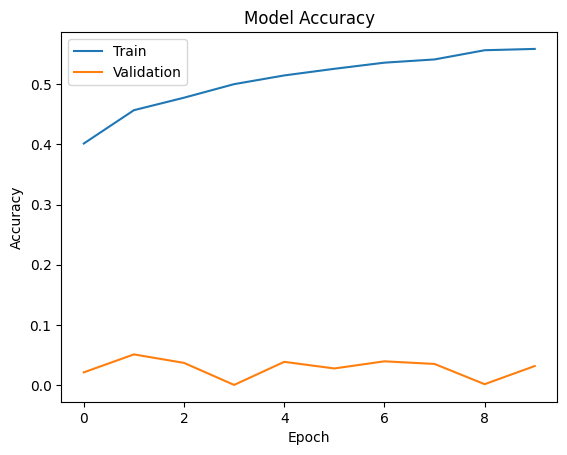

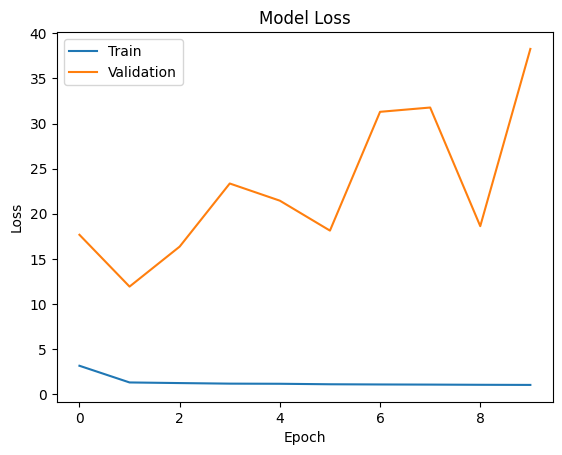

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


From the graphs it is clear that model is underfitting. Accracy for test data is nearly zero.

### VGG19 Model

In [7]:
base_model = VGG19(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_folder = '/content/dataset/train'
train_data = []
for emotion in os.listdir(train_folder):
    emotion_folder = os.path.join(train_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("RGB")  
                    img = img.resize(image_size)  
                    pixels = np.array(img) 
                    train_data.append({"filename": filename, "emotion": emotion, "pixels": pixels})

train_df = pd.DataFrame(train_data)

emotion_map_train = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
train_emotion = np.array([emotion_map_train[emotion] for emotion in train_df['emotion']])

train_pixels = np.stack(train_df['pixels'].to_numpy())

train_pixels = train_pixels.astype('float32')
train_pixels /= 255

train_folder = '/content/dataset/test'
train_data = []
for emotion in os.listdir(test_folder):
    emotion_folder = os.path.join(test_folder, emotion)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".png"):
                filepath = os.path.join(emotion_folder, filename)
                with Image.open(filepath) as img:
                    img = img.convert("RGB")  
                    img = img.resize(image_size)  
                    pixels = np.array(img) 
                    train_data.append({"filename": filename, "emotion": emotion, "pixels": pixels})

test_df = pd.DataFrame(test_data)

emotion_map_test = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
test_emotion = np.array([emotion_map_test[emotion] for emotion in test_df['emotion']])

test_pixels = np.stack(test_df['pixels'].to_numpy())

test_pixels = test_pixels.astype('float32')
test_pixels /= 255

history_2= model.fit(train_pixels, pd.get_dummies(train_emotion), epochs=10, batch_size=32)


Epoch 1/10
898/898 [==============================] - 35s 28ms/step - loss: 1.6531 - accuracy: 0.3419
Epoch 2/10
898/898 [==============================] - 25s 28ms/step - loss: 1.5626 - accuracy: 0.3928
Epoch 3/10
898/898 [==============================] - 25s 27ms/step - loss: 1.5186 - accuracy: 0.4123
Epoch 4/10
898/898 [==============================] - 25s 28ms/step - loss: 1.4967 - accuracy: 0.4221
Epoch 5/10
898/898 [==============================] - 25s 28ms/step - loss: 1.4774 - accuracy: 0.4257
Epoch 6/10
898/898 [==============================] - 25s 28ms/step - loss: 1.4597 - accuracy: 0.4373
Epoch 7/10
898/898 [==============================] - 24s 27ms/step - loss: 1.4416 - accuracy: 0.4421
Epoch 8/10
898/898 [==============================] - 25s 28ms/step - loss: 1.4273 - accuracy: 0.4485
Epoch 9/10
898/898 [==============================] - 25s 27ms/step - loss: 1.4197 - accuracy: 0.4525
Epoch 10/10
898/898 [==============================] - 25s 27ms/step - loss: 1.404

### Plotting Accuracy and Loss Curve

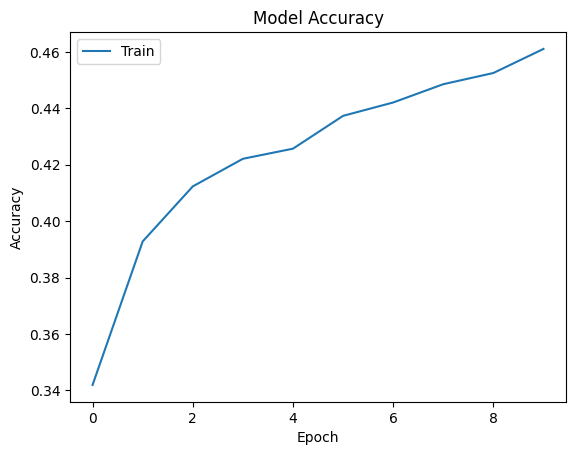

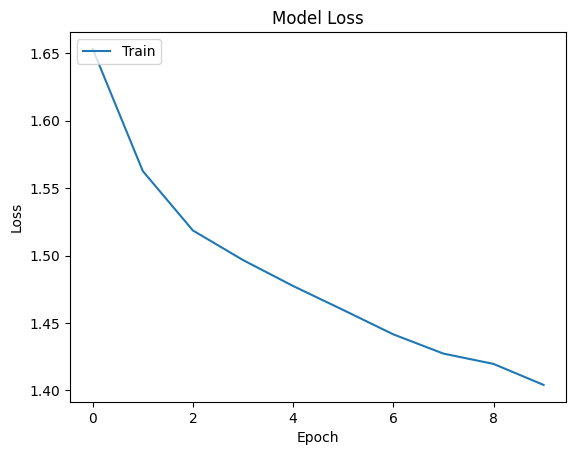

In [9]:
plt.plot(history_2.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

From my perspective here are the possible reasons for lower accuracy: 

1)Incorrect hyperparameters: The performance of the model can be affected by the choice of hyperparameters like the learning rate, batch size, and number of epochs.

2)Data preprocessing: The quality of the input data can affect the performance of the model. The images should be preprocessed properly, including normalization, resizing, and color conversion.

3)Inappropriate architecture: VGG16 and VGG19 are good choices for image classification tasks, but they may not be the best architecture for your specific problem.

Summary : For the model of Emotion Detection, I preprocessed the data into csv file from form of Image. To make it compatible with VGG16 and VGG19 model, I converted data from grayscale to colored, reshape the input data. around 50% acheived by VGG16 model for training data and 46-50% accuracy has been monitored by VGG19 model. I think it needs more time to figure out how can I reach to higher accuarcy on this, It could be one of the reasons I wrote above. It was very good experiments to do.